<a>https://github.com/dmackenz/Keras-Neuro-Evolution-Trading-Bot-Skeleton/blob/master/utils/Agent.py</a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gc
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

In [2]:
input_label = []
output_label = []
label = []

In [3]:
ficheiro = open("..\\Dataset\\28-02-2018(Time).csv", "r")

ficheiro.readline()
ficheiro.readline()
ficheiro.readline()
countLinha = 0
linha = ficheiro.readline()
while(linha != ""):
#for i in range(10000):
    linha = linha.split(",")
    linha.append(datetime.strptime(linha.pop(21) + "", '%d/%m/%Y %H:%M:%S').time())
    label.append(linha)
    countLinha += 1
    linha = ficheiro.readline()
ficheiro.close()

In [4]:
label.sort(key = lambda array : array[len(array) - 1])

In [5]:
for i in range(len(label)):
    label[i].pop(len(label[i]) - 1)

In [6]:
b = 0
a = 0
for i in range(len(label)):
    out = label[i].pop(18)
    if(out == "Benign"):
        out = 0
        b += 1
    else:
        out = 1
        a += 1
    output_label.append(out)
    input_label.append(label[i])

In [7]:
print(str(a) + " " + str(b))

68236 538666


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [ ]:
backup_input_label = input_label[:]
backup_output_label = output_label[:]

<h2>--------------------------------------------------------------------------------------------------------------------------------------------</h2>

In [11]:
inp_train_AE,inp_test_AE,out_train_AE,out_test_AE = train_test_split(input_label, input_label, test_size=0.2)

In [31]:
input_model = layers.Input(shape = (78,))
enc = layers.Dense(units = 64, activation = "relu", use_bias = True)(input_model)
enc = layers.Dense(units = 36, activation = "relu")(enc)
dec = layers.Dense(units = 64, activation = "relu", use_bias = True)(enc)
dec = layers.Dense(units = 78, activation = "relu", use_bias = True)(dec)
auto_encoder = keras.Model(input_model, dec)

In [32]:
encoder = keras.Model(input_model, enc)

decoder_input = layers.Input(shape = (36,))
decoder_layer = auto_encoder.layers[-2](decoder_input)
decoder_layer = auto_encoder.layers[-1](decoder_layer)
decoder = keras.Model(decoder_input, decoder_layer)

In [33]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025),loss = "mean_squared_error", metrics = ['accuracy'])

In [34]:
train = auto_encoder.fit(x = inp_train_AE, y = out_train_AE, epochs = 10, verbose = 1, shuffle = True)

Epoch 1/10
15173/15173 [==============================] - 22s 1ms/step - loss: 0.0076 - accuracy: 0.7058 0s - loss: 0.0076 - accu
Epoch 2/10
15173/15173 [==============================] - 23s 1ms/step - loss: 0.0055 - accuracy: 0.7727
Epoch 3/10
15173/15173 [==============================] - 27s 2ms/step - loss: 0.0055 - accuracy: 0.7688
Epoch 4/10
15173/15173 [==============================] - 23s 1ms/step - loss: 0.0055 - accuracy: 0.7674
Epoch 5/10
15173/15173 [==============================] - 22s 1ms/step - loss: 0.0055 - accuracy: 0.7681
Epoch 6/10
15173/15173 [==============================] - 24s 2ms/step - loss: 0.0055 - accuracy: 0.7691
Epoch 7/10
15173/15173 [==============================] - 24s 2ms/step - loss: 0.0055 - accuracy: 0.7705
Epoch 8/10
15173/15173 [==============================] - 23s 1ms/step - loss: 0.0055 - accuracy: 0.7708
Epoch 9/10
15173/15173 [==============================] - 22s 1ms/step - loss: 0.0055 - accuracy: 0.7700
Epoch 10/10
15173/15173 [=====

In [38]:
error = keras.losses.mean_squared_error(out_test_AE, auto_encoder.predict(inp_test_AE)).numpy()
total = 0
for er in error:total += er
print(total / len(error))

0.005487085838177882


In [39]:
encoder.save("Infiltration(28-02-2018)E.h5")

In [9]:
encoder = keras.models.load_model("Infiltration(28-02-2018)E.h5")

In [10]:
input_label = encoder.predict(input_label)

In [11]:
inp = []
out = []
num = 0
for i in range(len(input_label) - 20 + 1):
    aux = []
    for j in range(i, i + 20):
        aux.append(input_label[j])
    inp.append(aux)
    out.append(output_label[i + 20 - 1])

In [12]:
print(np.array(inp).shape)

(606883, 20, 36)


In [13]:
inp_train, inp_test, out_train, out_test = train_test_split(inp, out, test_size = 0.2, shuffle = False)

In [14]:
from Agente import Agente
from random import randint

In [15]:
def createModel():
    return keras.Sequential([
            layers.Input((20, 36)),
            layers.LSTM(units=64, return_sequences=True, use_bias=True),
            layers.LSTM(units=32, return_sequences=False, use_bias=True),
            layers.Dense(units=2, activation="softmax")
        ])

In [16]:
population = [Agente(createModel, 0.2) for i in range(5)]

In [17]:
def sortFitness(population):
    for i in range(len(population)):
        for j in range(len(population) - 1):
            if(population[j].getFitness() > population[j + 1].getFitness()):
                aux = population[j]
                population[j] = population[j + 1]
                population[j + 1] = aux

In [18]:
def fit(population, number_generations, batch_size, inp_train_label, out_train_label):
    train_history = []
    for gen in range(number_generations):
        sample_seed = randint(0, len(inp_train_label) - batch_size)
        batch_train_input = inp_train_label[sample_seed : sample_seed + batch_size]
        batch_train_output = out_train_label[sample_seed : sample_seed + batch_size]
        for i in range(len(population)): population[i].calculateFitness(batch_train_output, population[i].predict(np.array(batch_train_input)))
        sortFitness(population)
        print("Generation " + str(gen) + ": " + str(population[0].getFitness()))
        train_history.append(population[0].getFitness())
        for i in range(len(population)): population[i].resetFitness()
        half = int(len(population) / 2)
        for i in range(0, half):
            population[i + half] = population[i].copy()
            population[i + half].mutate()
    return train_history

In [20]:
train = fit(population, 50, 1000, inp_train, out_train)

Generation 0: 0.6931470594465733
Generation 1: 0.6931470429301262
Generation 2: 0.6931470081567764
Generation 3: 0.6931470752239227
Generation 4: 0.6931470598578453
Generation 5: 0.6931471131920814
Generation 6: 0.6931471209466458
Generation 7: 0.6931471320509911
Generation 8: 0.6931471812129021
Generation 9: 0.6931471758186817
Generation 10: 0.6931471893012524
Generation 11: 0.6931471828639507
Generation 12: 0.6931471824645996
Generation 13: 0.6931471824645996
Generation 14: 0.6931471824645996
Generation 15: 0.6931471824645996
Generation 16: 0.6931471824645996
Generation 17: 0.6931471824645996
Generation 18: 0.6931471824645996
Generation 19: 0.6931471824645996
Generation 20: 0.6931471824645996
Generation 21: 0.6931471824645996
Generation 22: 0.6931471824645996
Generation 23: 0.6931471824645996
Generation 24: 0.6931471824645996
Generation 25: 0.6931471824645996
Generation 26: 0.6931471824645996
Generation 27: 0.6931471824645996
Generation 28: 0.6931471824645996
Generation 29: 0.6931471

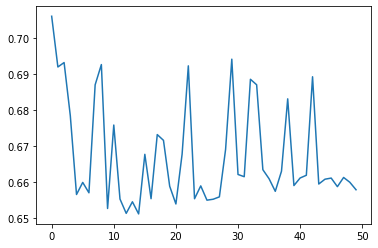

In [35]:
plt.plot(train)
plt.show()